In [1]:
import scvelo as scv
import pickle
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", "DeprecationWarning")

In [2]:
with open("../data/merge_velocity.pickle", 'rb') as f:
    merge = pickle.load(f)

In [3]:
DCtum = merge[merge.obs["Population"].isin(["cDC1", "cDC2", "Mature_DC"]),]
DCtum = DCtum[DCtum.obs["Stage"] == "Tumor",]

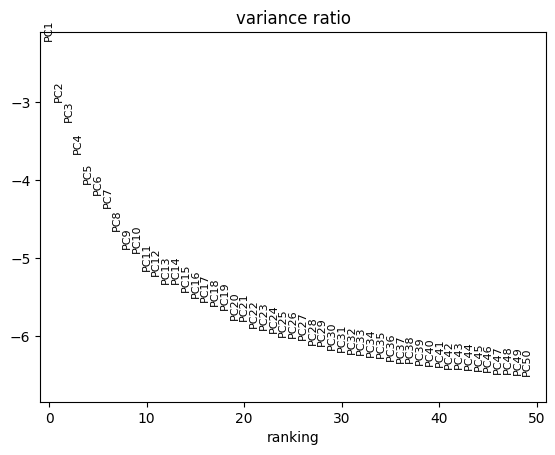

2024-06-19 09:39:37,000 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-19 09:39:40,610 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-19 09:39:40,651 - harmonypy - INFO - Iteration 1 of 10
2024-06-19 09:39:41,445 - harmonypy - INFO - Iteration 2 of 10
2024-06-19 09:39:42,196 - harmonypy - INFO - Iteration 3 of 10
2024-06-19 09:39:42,852 - harmonypy - INFO - Converged after 3 iterations


In [4]:
sc.pp.normalize_total(DCtum)
sc.pp.log1p(DCtum)
sc.pp.highly_variable_genes(DCtum)
sc.tl.pca(DCtum)
sc.pl.pca_variance_ratio(DCtum, n_pcs=50, log=True)
sc.external.pp.harmony_integrate(DCtum, "orig.ident")

sc.pp.neighbors(DCtum,  use_rep = "X_pca_harmony", )
sc.tl.umap(DCtum)
sc.tl.louvain(DCtum, resolution = 0.5)

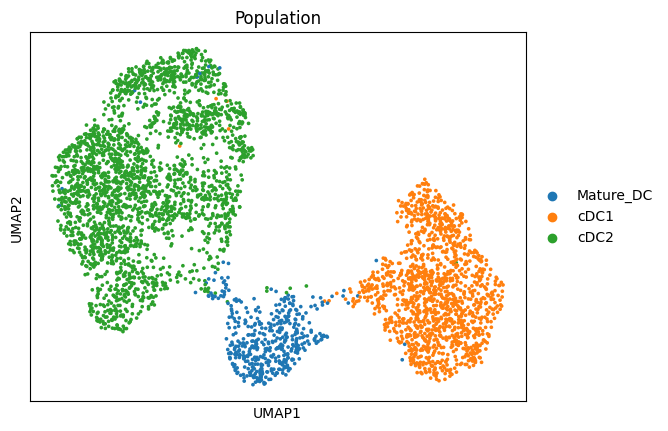

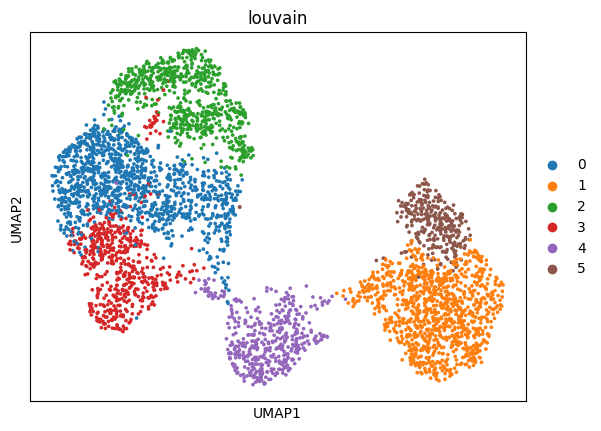

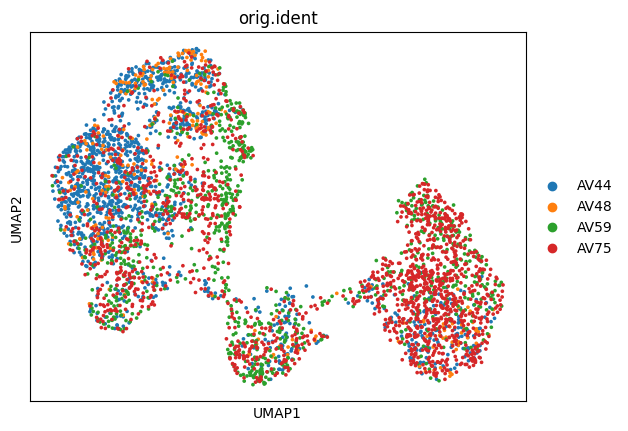

In [5]:
sc.pl.umap(DCtum, color = 'Population')
sc.pl.umap(DCtum, color = 'louvain')
sc.pl.umap(DCtum, color = 'orig.ident')

Effet batch ?

In [6]:
DCtum.raw.var.index = DCtum.raw.var._index 

categories: 0, 1, 2, etc.
var_group_labels: 5


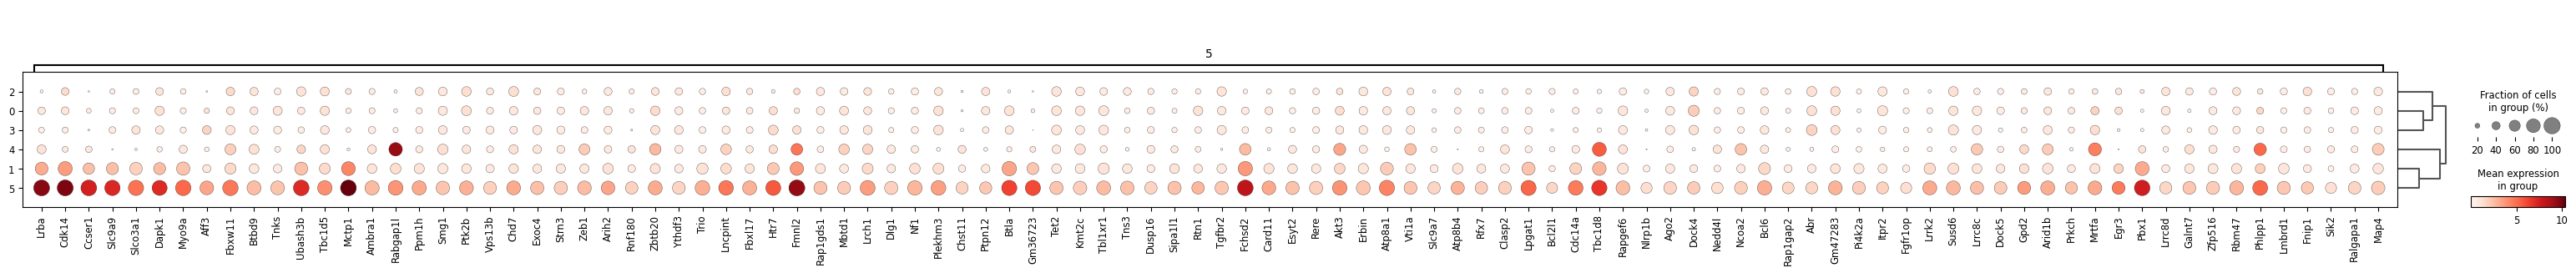

categories: Mature_DC, cDC1, cDC2
var_group_labels: 5


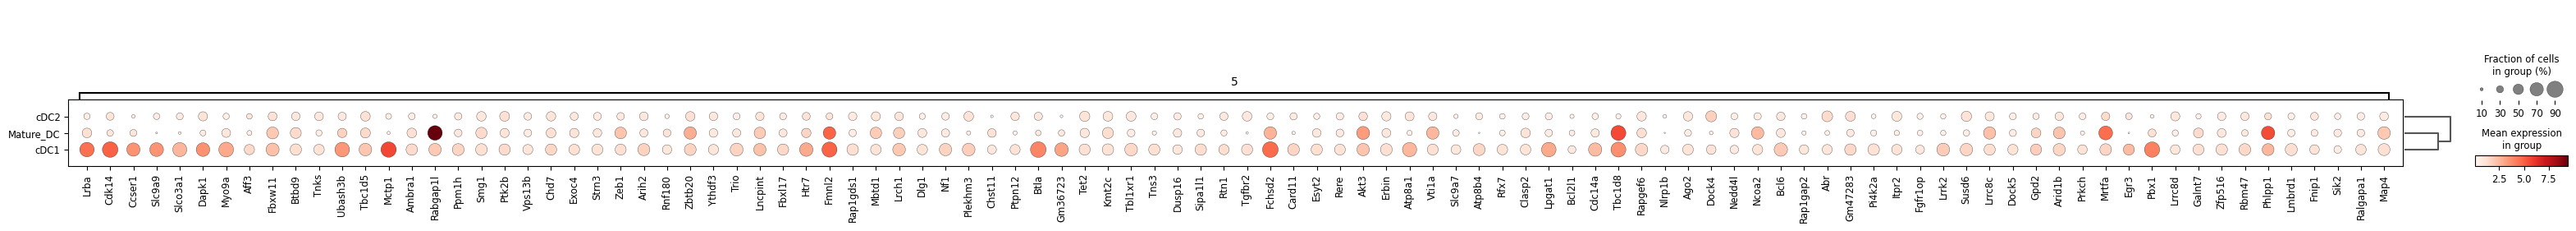

In [7]:
# DEG cluster 5 vs autre cDC1
import matplotlib
FIGSIZE = (10, 10)
matplotlib.rcParams["figure.figsize"] = FIGSIZE
sc.tl.rank_genes_groups(DCtum, groups = ["5"], reference="1", groupby="louvain")
sc.tl.filter_rank_genes_groups(DCtum, min_fold_change=-1000, min_in_group_fraction = 0.1)
sc.pl.rank_genes_groups_dotplot(DCtum, groups = ["5"], groupby="louvain", key = "rank_genes_groups_filtered", n_genes=100)
sc.pl.rank_genes_groups_dotplot(DCtum, groups = ["5"], groupby="Population", key = "rank_genes_groups_filtered", n_genes=100)


In [8]:
df = sc.get.rank_genes_groups_df(DCtum, group = "5", key = "rank_genes_groups_filtered")
df = df.dropna()
df_sorted = df.sort_values("logfoldchanges", ascending = False)

In [27]:
df_stat = df_sorted[df_sorted["pvals_adj"] < 0.01]
df_stat["-log_pval"] = -1*np.log10(df_stat["pvals_adj"])

liste = []
threshold = 1
for i in df_stat.values: #2 = foldchange, 4 = pval_adj
    if i[2] > threshold:
        liste.append("UP")
    elif i[2] < -threshold : 
        liste.append("DOWN")
    else:
        liste.append("NONE")
df_stat["assignation"] = liste

In [28]:
df_up = df_stat[df_stat["assignation"] == "UP"]
print(f"{df_up.shape[0]} DEG with logFC > {threshold}, showing top 20 : ")
df_up[0:20]

1395 DEG with logFC > 1, showing top 20 : 


names     scores  logfoldchanges         pvals     pvals_adj  \
1       Lrba  13.248471        9.522163  1.465699e-32  1.874042e-28   
4      Cdk14  12.582017        9.152315  6.528643e-30  2.385006e-26   
787    Plet1   5.678344        8.933582  2.868913e-08  6.934200e-07   
37     Mctp1  10.824342        8.811263  1.070710e-23  7.020562e-21   
79     Fmnl2   9.630208        8.315177  1.781433e-19  5.061644e-17   
373    Cadm1   7.186295        8.181416  5.019454e-12  2.635677e-10   
9     Ccser1  12.342406        7.423719  4.004128e-29  1.023936e-25   
10    Slc9a9  12.158964        6.977826  2.057851e-28  4.783943e-25   
31   Ubash3b  10.995808        6.857730  4.853243e-24  3.545918e-21   
20     Dapk1  11.409295        6.645250  1.146900e-25  1.333115e-22   
112   Fchsd2   8.961789        6.548282  2.329945e-17  4.583181e-15   
177     Pbx1   8.306467        6.514555  2.862115e-15  3.282063e-13   
138   Tbc1d8   8.633017        5.773997  2.762221e-16  4.229671e-14   
322    Nr4a2   7.480555        5.764233  6.436812e-13  4.044279e-11   
99   Gm36723   9.183585        5.664971  5.111657e-18  1.126856e-15   
491     Egr1   6.688573        5.359008  9.404663e-11  3.799305e-09   
73      Htr7   9.738195        5.233943  6.490701e-20  1.999762e-17   
68   Lncpint   9.808214        5.211862  5.580772e-20  1.740384e-17   
455     Aff1   6.826808        5.179321  4.577559e-11  1.990771e-09   
665    Nr4a3   6.047717        5.069476  3.830892e-09  1.111959e-07   

     -log_pval assignation  
1    27.727221          UP  
4    25.622510          UP  
787   6.159004          UP  
37   20.153628          UP  
79   16.295708          UP  
373   9.579108          UP  
9    24.989727          UP  
10   24.320214          UP  
31   20.450271          UP  
20   21.875133          UP  
112  14.338833          UP  
177  12.483853          UP  
138  13.373693          UP  
322  10.393159          UP  
99   14.948132          UP  
491   8.420296          UP  
73   16.699022          UP  
68   16.759355          UP  
455   8.700979          UP  
665   6.953911          UP

In [29]:
df_down = df_stat[df_stat["assignation"] == "DOWN"]
df_down = df_down.sort_values("logfoldchanges", ascending = True)
print(f"{df_down.shape[0]} DEG with logFC < {-threshold}, showing top 20 : ")
df_down[0:20]

26 DEG with logFC < -1, showing top 20 : 


names    scores  logfoldchanges         pvals     pvals_adj  \
24815     Ifit3 -3.498995       -1.849047  4.903143e-04  4.562706e-03   
25318    Cldnd1 -5.721616       -1.781299  1.519380e-08  3.897050e-07   
25414  BC028528 -6.499429       -1.779464  1.912383e-10  7.191686e-09   
25173     Isg20 -4.809174       -1.626036  1.830022e-06  3.036816e-05   
25321     Ifi47 -5.727533       -1.567656  1.436357e-08  3.702673e-07   
25336      Fdps -5.860468       -1.480977  7.471748e-09  2.052283e-07   
25369     Cxcr3 -6.041496       -1.362317  2.385353e-09  7.287725e-08   
25408      Rac2 -6.417678       -1.309733  2.563546e-10  9.471807e-09   
25238    Unc119 -5.209328       -1.241120  2.742747e-07  5.466682e-06   
25058     Fcgr1 -4.382676       -1.228836  1.320518e-05  1.793324e-04   
25042     Tnni2 -4.286355       -1.215810  2.164931e-05  2.800285e-04   
25268     Ptrh2 -5.404111       -1.207296  9.222067e-08  2.008745e-06   
25464     Psmd6 -6.958565       -1.201102  8.751643e-12  4.365193e-10   
25412  Pafah1b3 -6.487260       -1.182582  2.097175e-10  7.840490e-09   
25422    Isyna1 -6.539876       -1.177919  1.290671e-10  5.062121e-09   
25124      Igtp -4.610693       -1.176038  4.691349e-06  7.107060e-05   
25011      Zbp1 -4.177939       -1.173956  3.386891e-05  4.192138e-04   
25130  BC051226 -4.630914       -1.147894  4.334004e-06  6.624576e-05   
25226     Batf3 -5.123379       -1.100369  4.289424e-07  8.191872e-06   
25230      Ppa1 -5.158050       -1.083592  3.452379e-07  6.744403e-06   

       -log_pval assignation  
24815   2.340777        DOWN  
25318   6.409264        DOWN  
25414   8.143169        DOWN  
25173   4.517582        DOWN  
25321   6.431485        DOWN  
25336   6.687763        DOWN  
25369   7.137408        DOWN  
25408   8.023567        DOWN  
25238   5.262276        DOWN  
25058   3.746341        DOWN  
25042   3.552798        DOWN  
25268   5.697075        DOWN  
25464   9.359997        DOWN  
25412   8.105657        DOWN  
25422   8.295667        DOWN  
25124   4.148310        DOWN  
25011   3.377564        DOWN  
25130   4.178842        DOWN  
25226   5.086617        DOWN  
25230   5.171056        DOWN

<Axes: xlabel='gene_ratio', ylabel='name'>

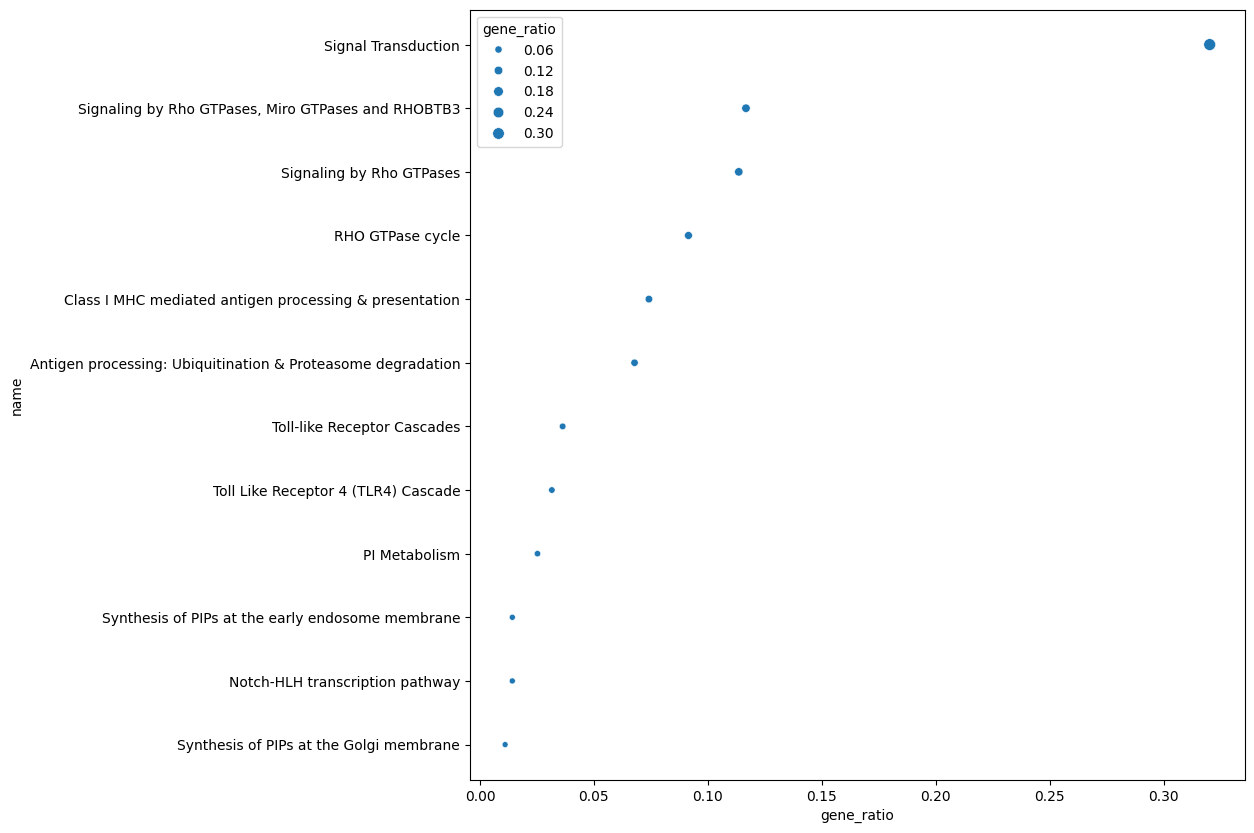

In [30]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "REAC"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")

<Axes: xlabel='gene_ratio', ylabel='name'>

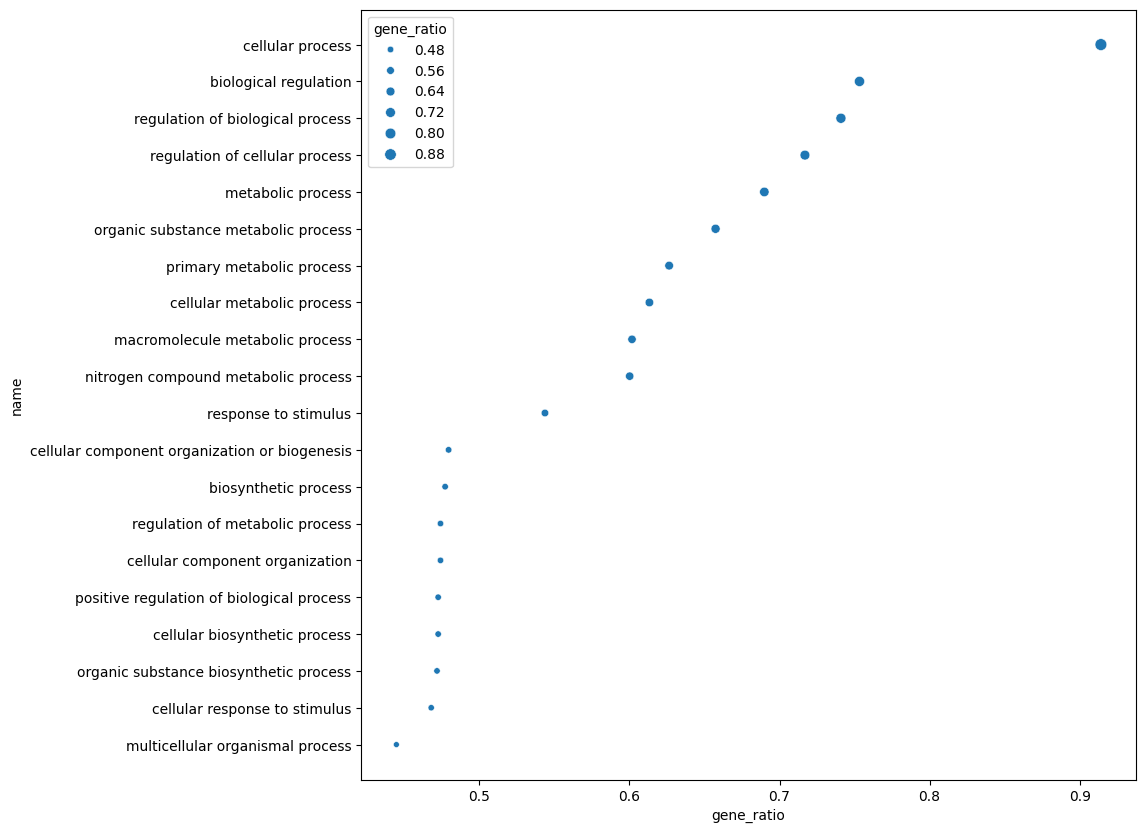

In [31]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "GO:BP"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")

<Axes: xlabel='gene_ratio', ylabel='name'>

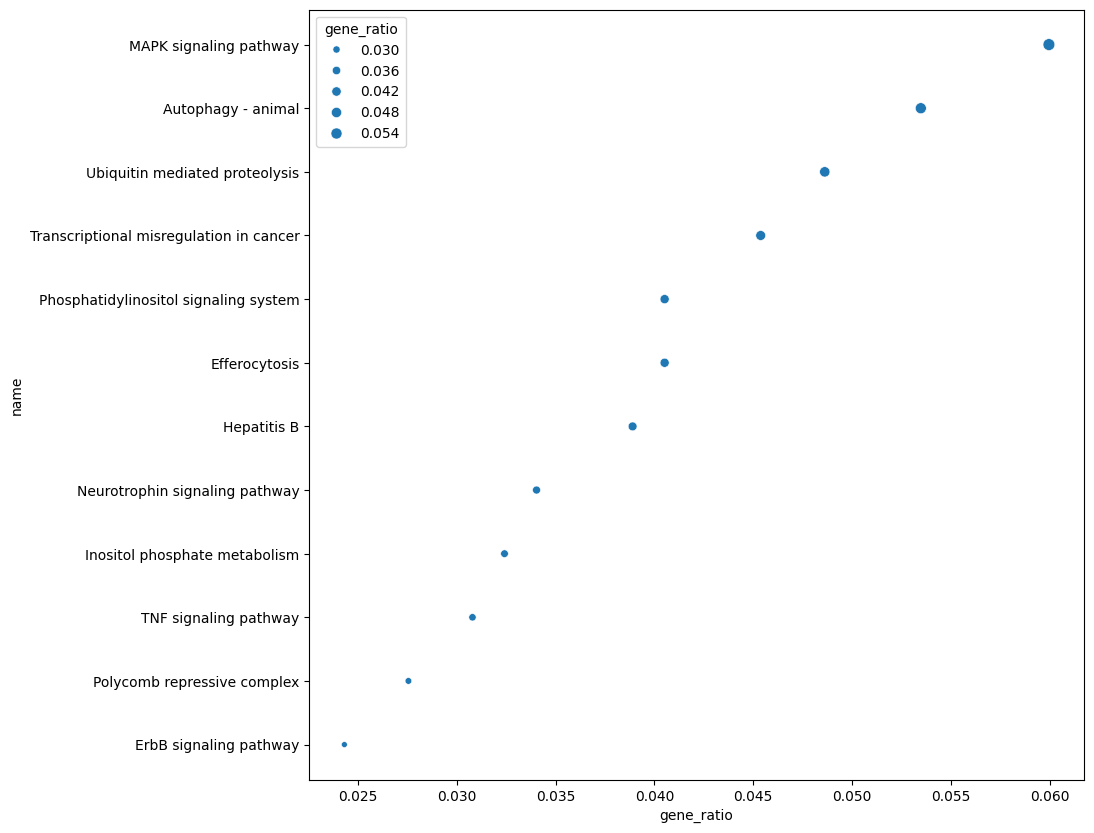

In [32]:
up_Early_vs_Healthy_cDC1 = list(df_up["names"].values)
df_enrich = sc.queries.enrich(up_Early_vs_Healthy_cDC1,org = "mmusculus")

np.unique(df_enrich["source"])

df_enrich["-log_pval"] = -1*np.log10(df_enrich["p_value"])
df_enrich["gene_ratio"] = [df_enrich.loc[i, "intersection_size"] / df_enrich.loc[i, "query_size"] for i in df_enrich.index]

temp = df_enrich[df_enrich["source"] == "KEGG"]

test = temp.sort_values("gene_ratio", ascending = False)

sns.scatterplot(test[0:20], x = "gene_ratio", y = "name", size = "gene_ratio")

In [60]:
scv.pp.filter_and_normalize(DCtum, n_top_genes=2000)
scv.pp.moments(DCtum)

#scv.tl.umap(DC_merge)

#scv.tl.recover_dynamics(DCtum)
#scv.tl.velocity(DCtum, mode = "dynamical")

scv.tl.velocity(DCtum)
scv.tl.velocity_graph(DCtum)

Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

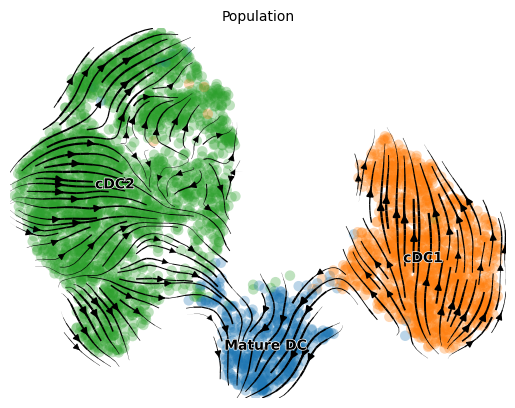

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

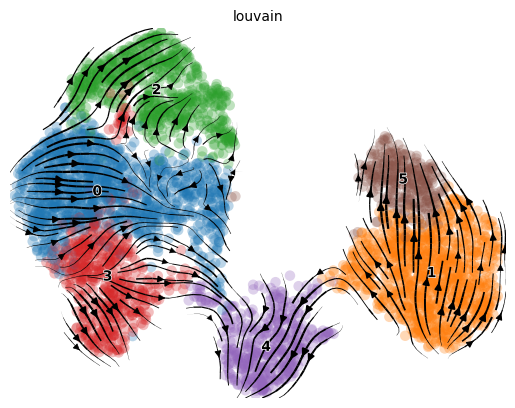

In [61]:
scv.pl.velocity_embedding_stream(DCtum, basis='umap', color = "Population")
scv.pl.velocity_embedding_stream(DCtum, basis='umap', color = "louvain")

In [62]:
sc.tl.diffmap(DCtum)
DCtum.obsm["X_diffmap_2D"] = DCtum.obsm["X_diffmap"][:,1:]

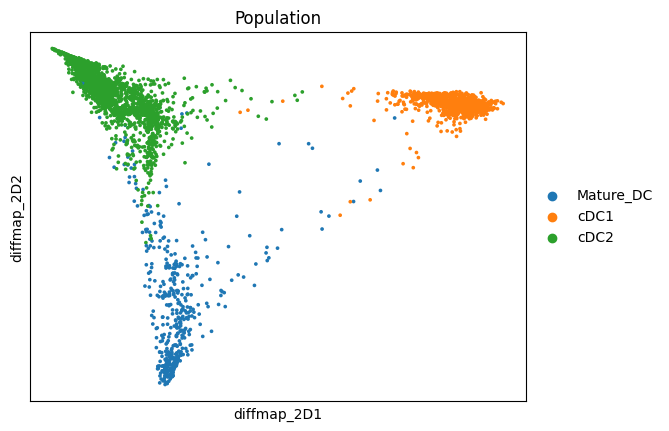

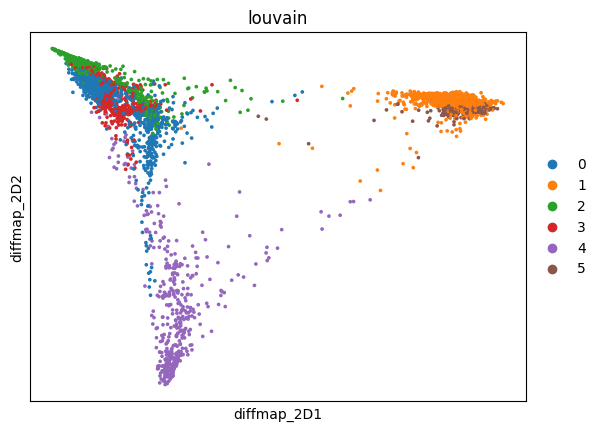

In [63]:
sc.pl.embedding(DCtum, color = 'Population', basis = "diffmap_2D")
sc.pl.embedding(DCtum, color = 'louvain', basis = "diffmap_2D")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_diffmap', embedded velocity vectors (adata.obsm)


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

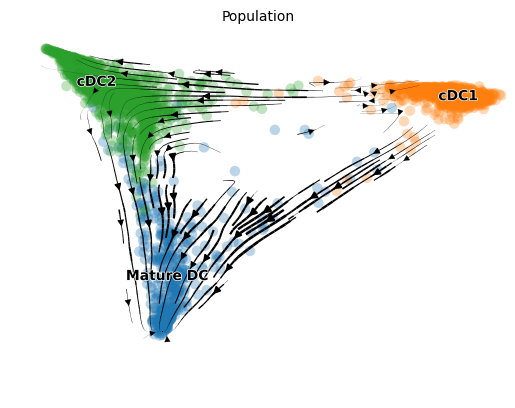

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

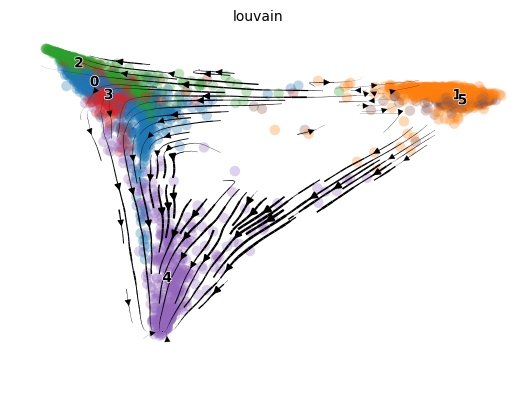

In [64]:
scv.pl.velocity_embedding_stream(DCtum, basis='diffmap', color = "Population")
scv.pl.velocity_embedding_stream(DCtum, basis='diffmap', color = "louvain")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

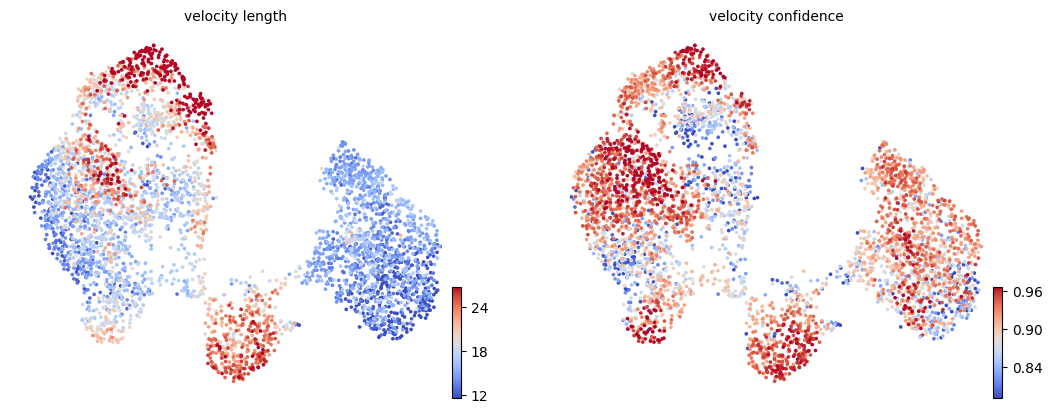

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

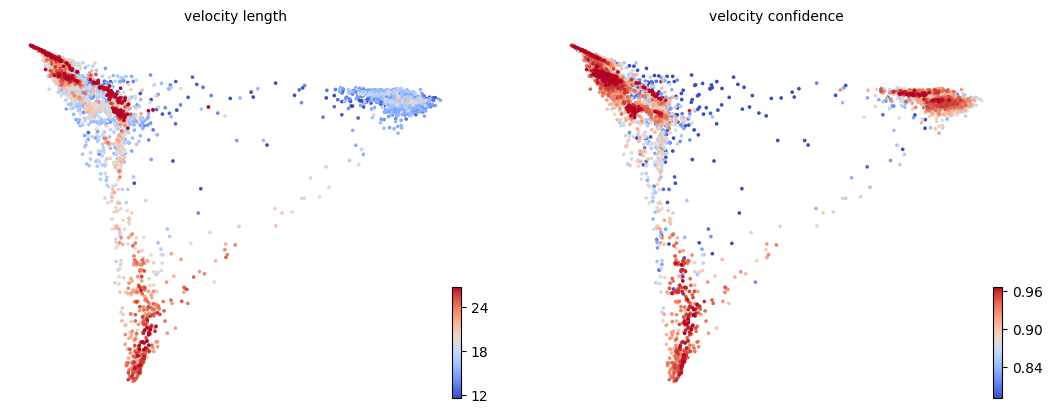

In [65]:
scv.tl.velocity_confidence(DCtum)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(DCtum, c=keys, cmap='coolwarm', perc=[5, 95])
scv.pl.scatter(DCtum, c=keys, cmap='coolwarm', perc=[5, 95], basis = "diffmap")

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

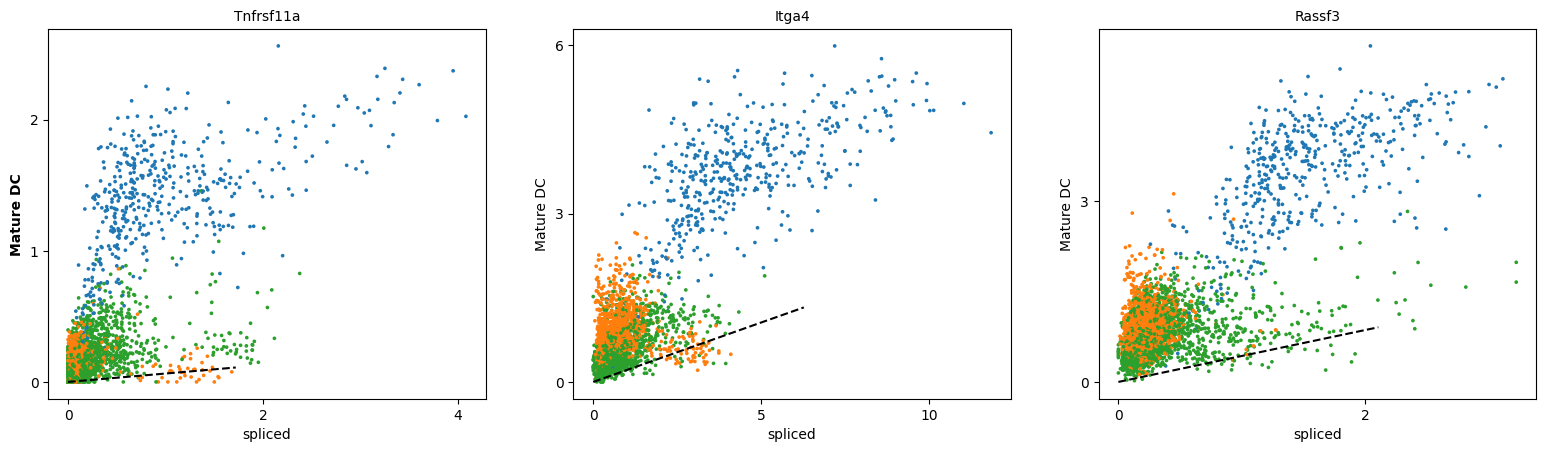

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

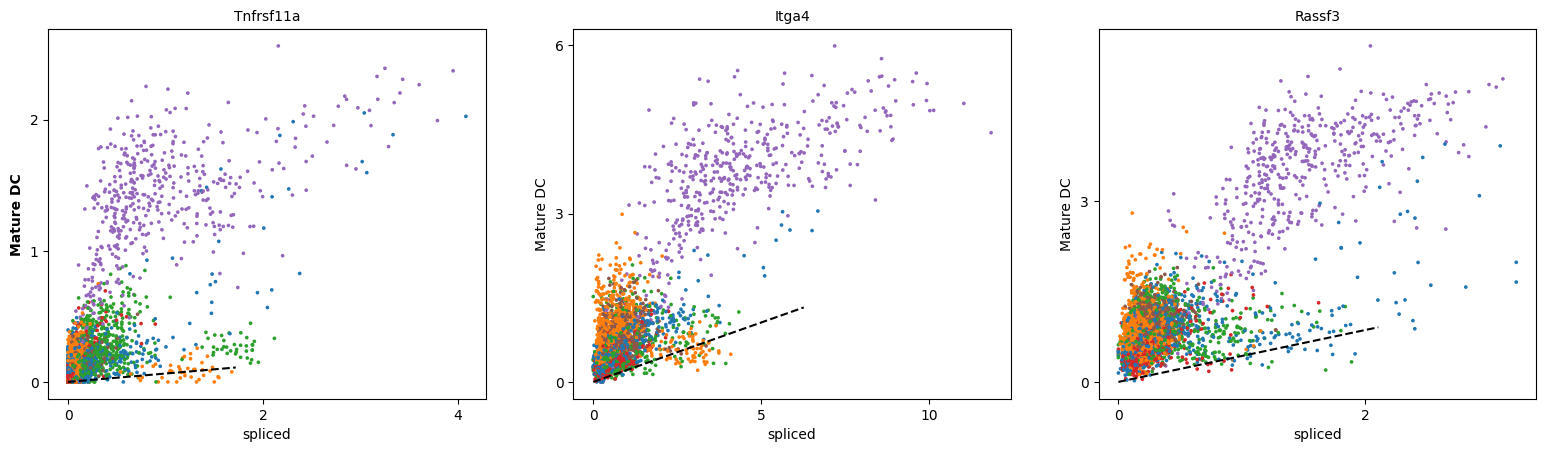

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

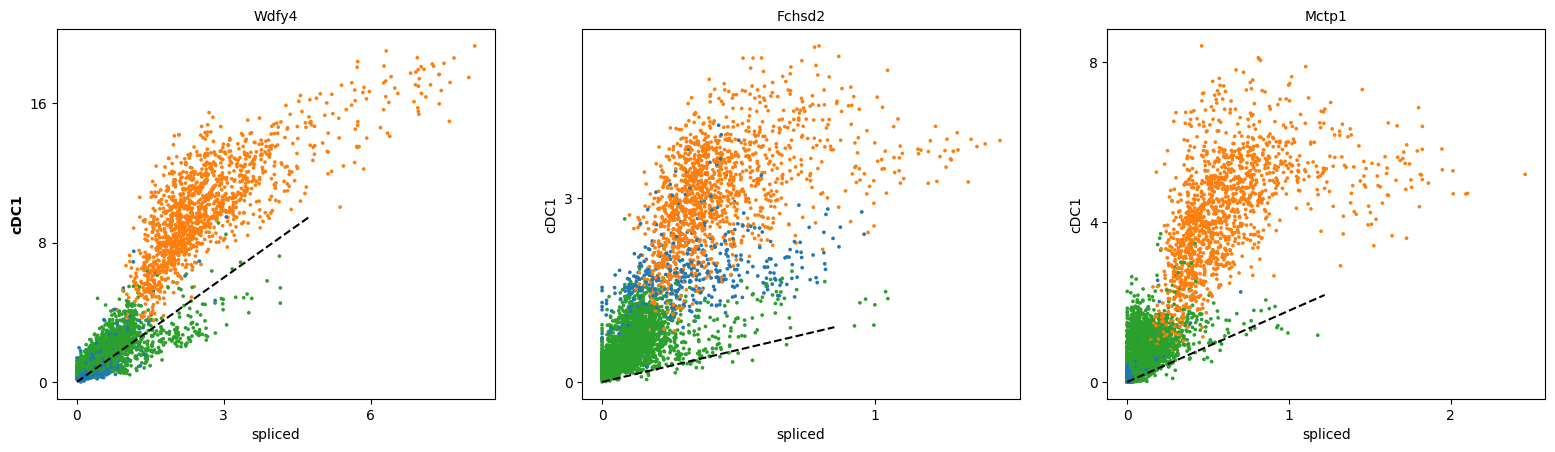

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

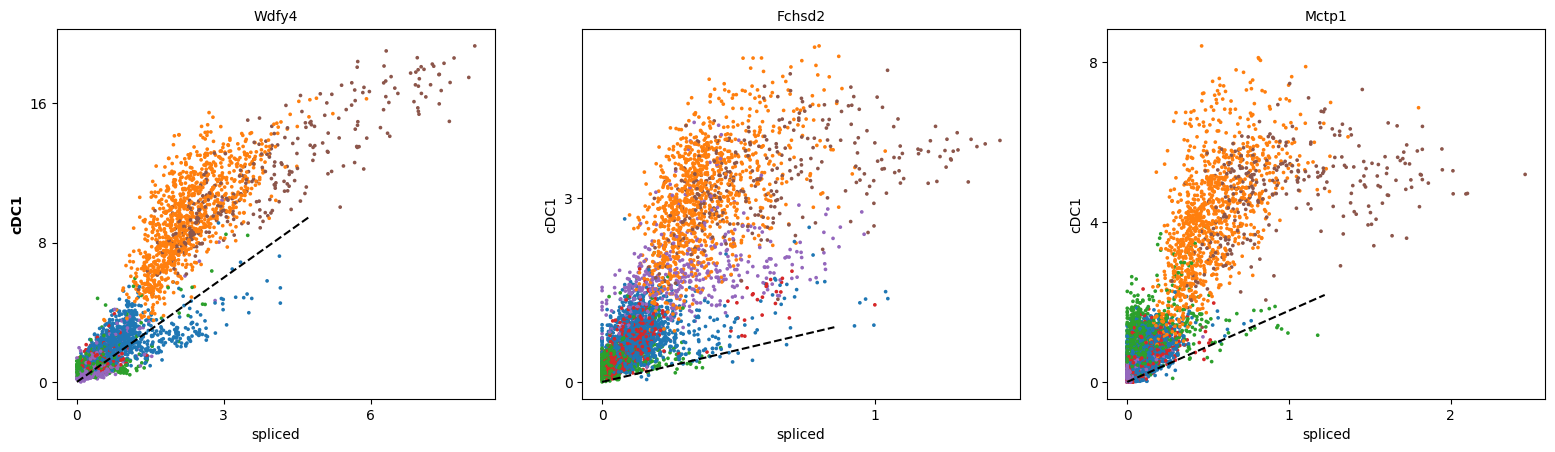

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

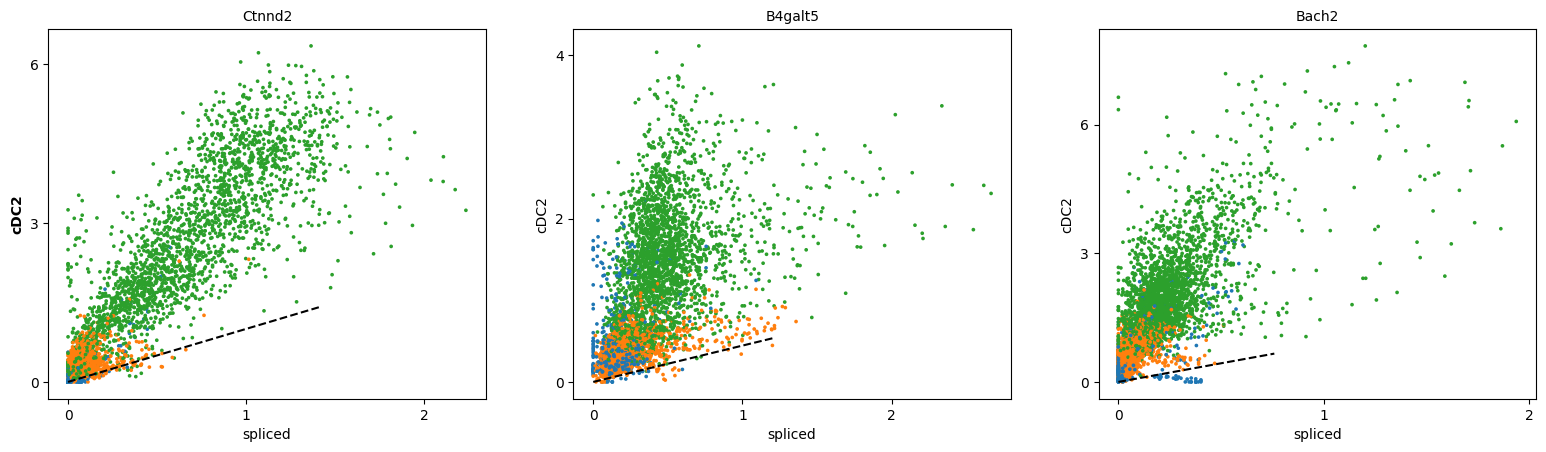

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

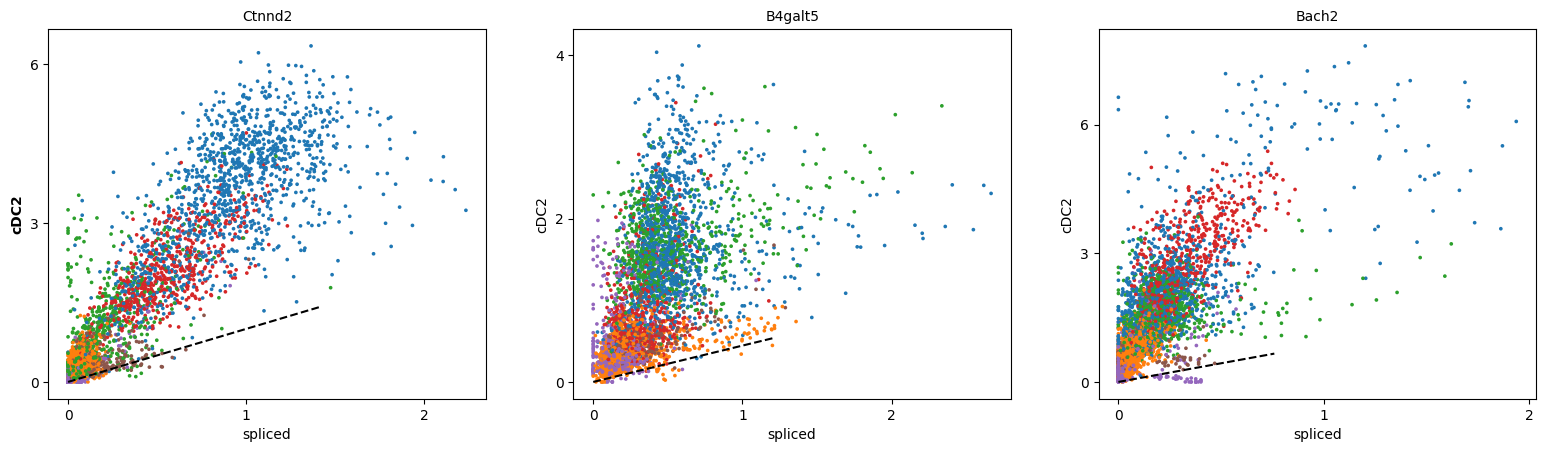

In [82]:
scv.tl.rank_velocity_genes(DCtum, groupby='Population', min_corr=.3)

df = pd.DataFrame(DCtum.uns['rank_velocity_genes']['names'])
df.head()

scv.pl.scatter(DCtum, df.head(3)["Mature_DC"].values, color = 'Population', ylabel = 'Mature_DC', ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["Mature_DC"].values, color = 'louvain', ylabel = 'Mature_DC', ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["cDC1"].values, color = 'Population', ylabel = "cDC1", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["cDC1"].values, color = 'louvain', ylabel = "cDC1", ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["cDC2"].values, color = 'Population', ylabel = "cDC2", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["cDC2"].values, color = 'louvain', ylabel = "cDC2", ncols=3, linewidth=1.5)

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

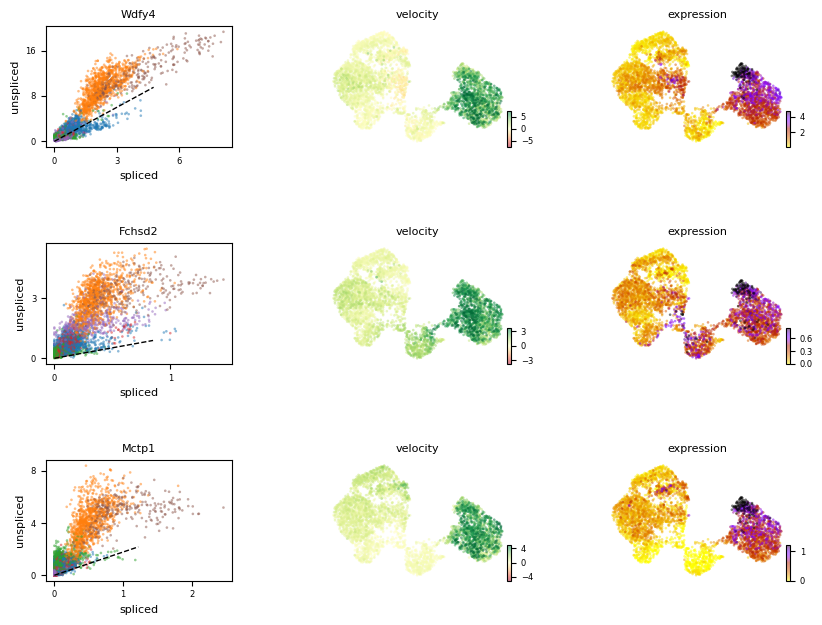

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

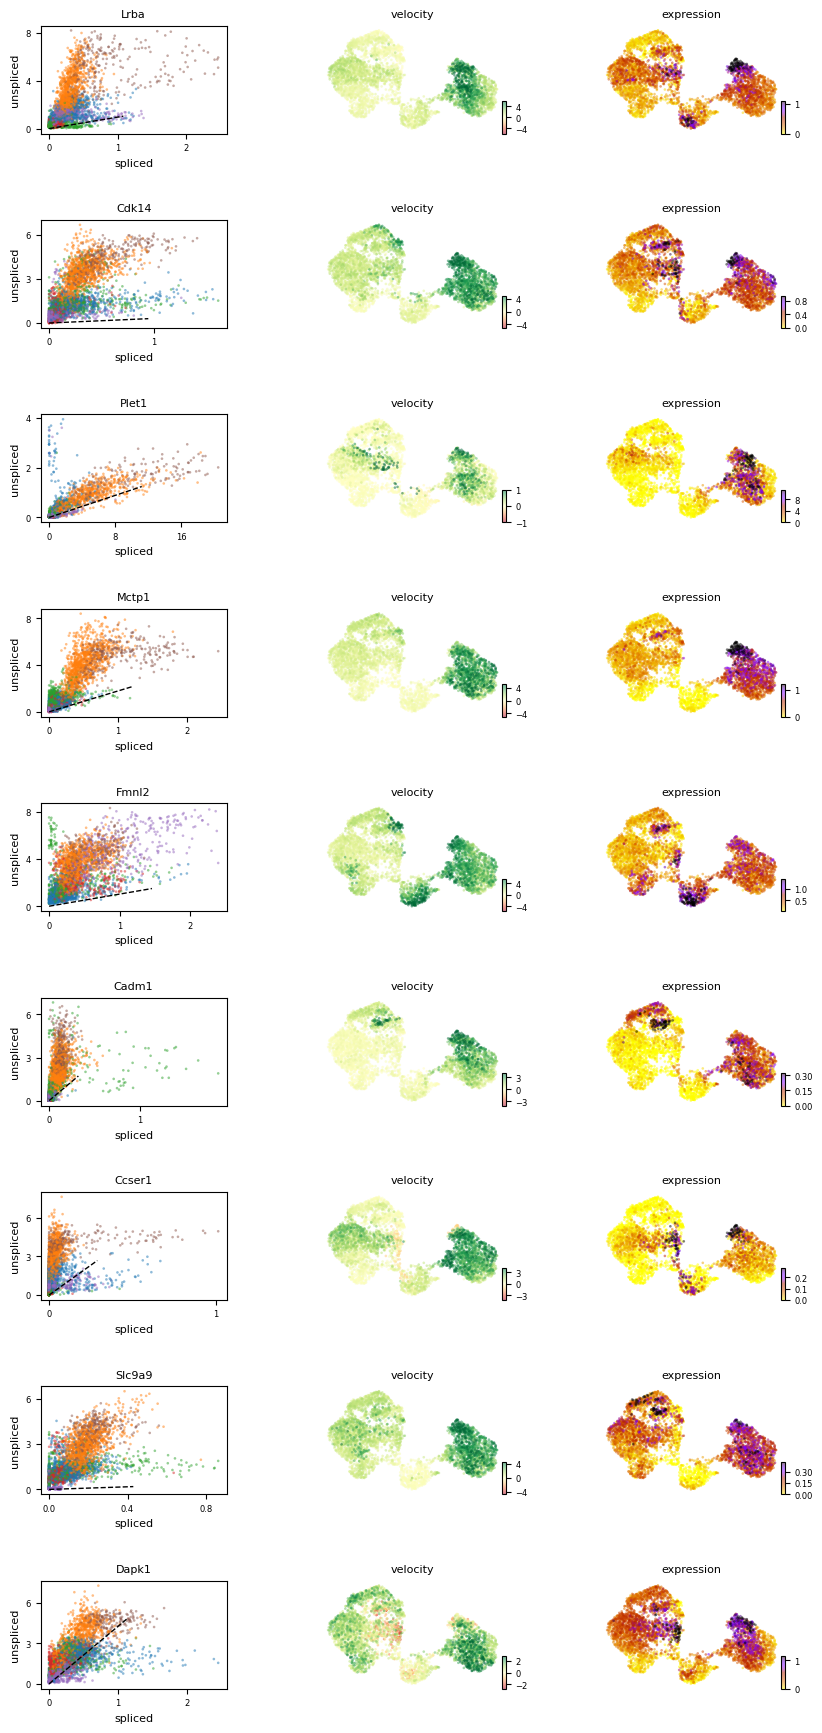

In [86]:
scv.pl.velocity(DCtum, df.head(3)["cDC1"].values)

scv.pl.velocity(DCtum, df_up.names.values[0:10])

Wdfy4 required for cross presentation

Plet1 -> Cell migration

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

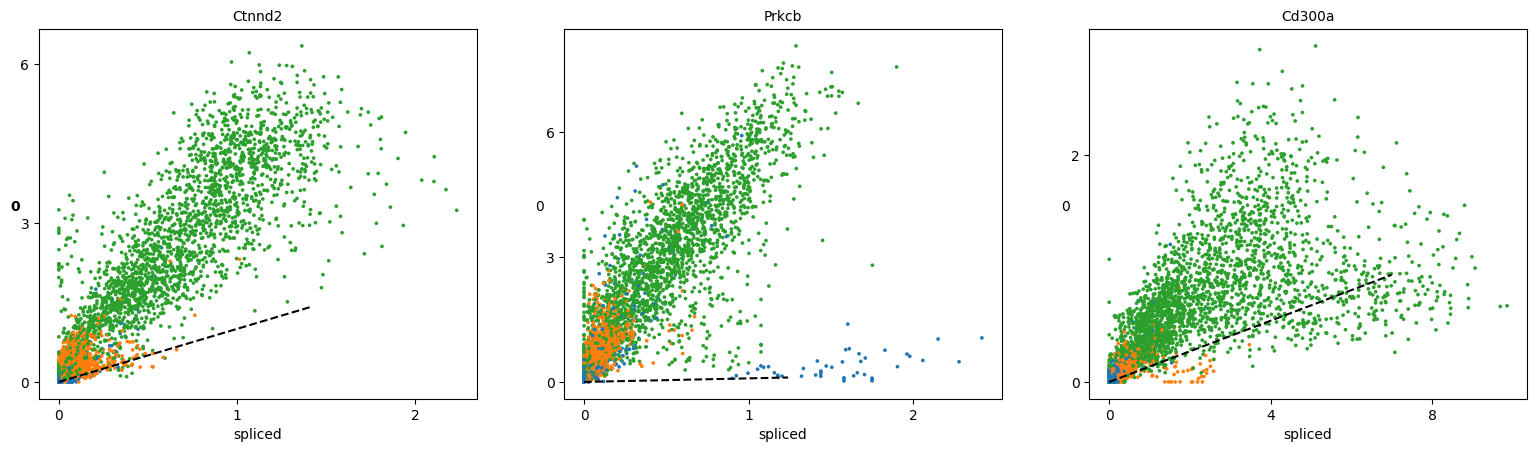

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

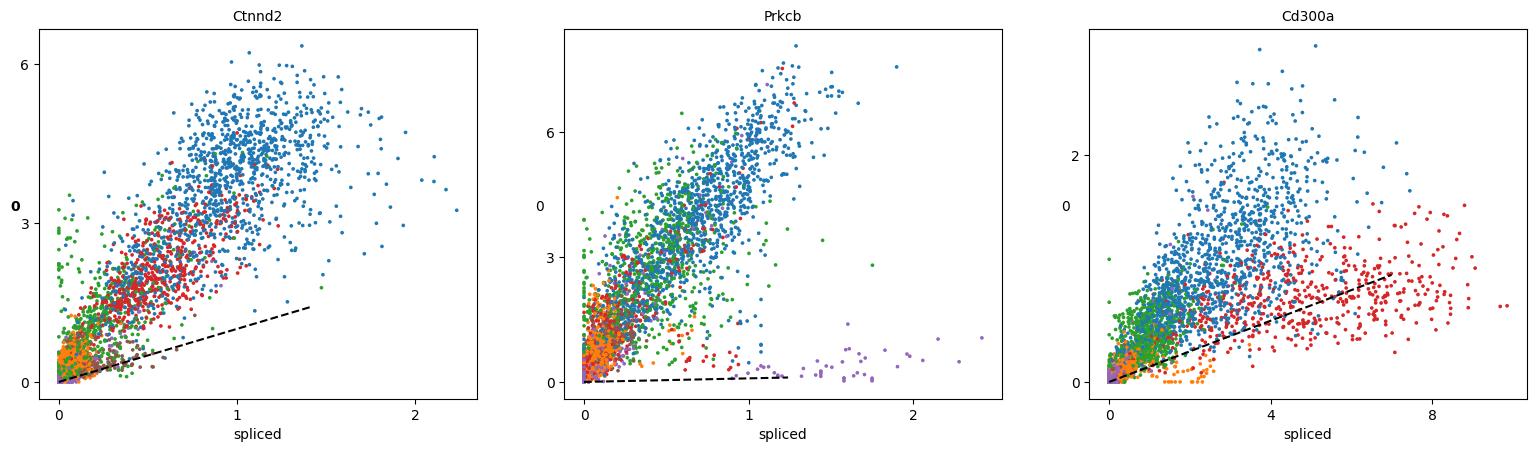

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

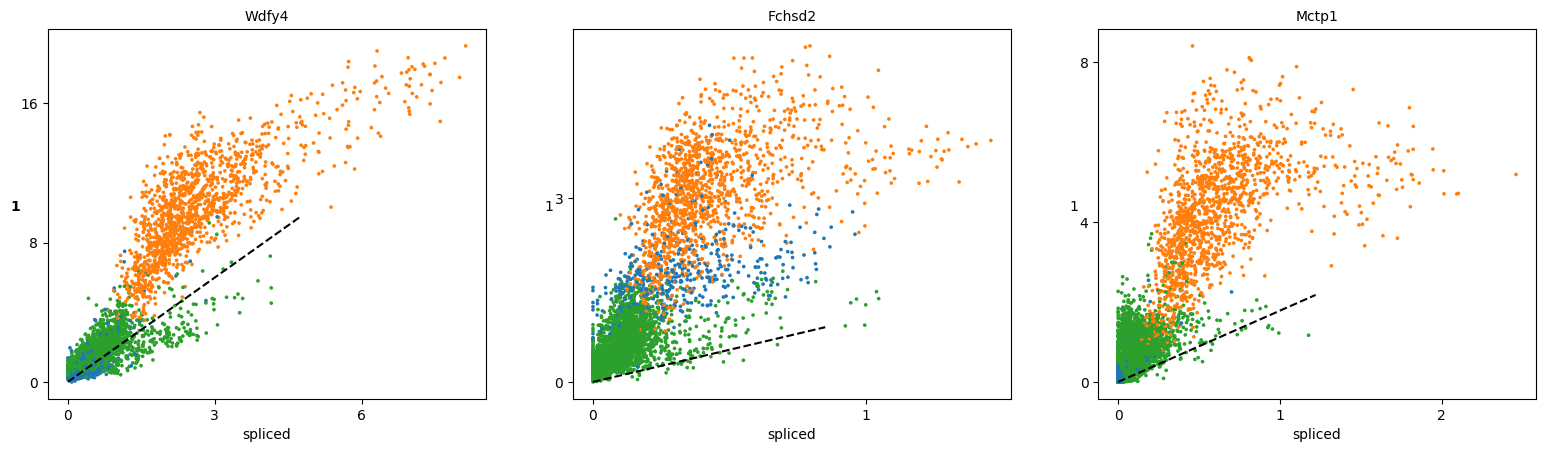

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

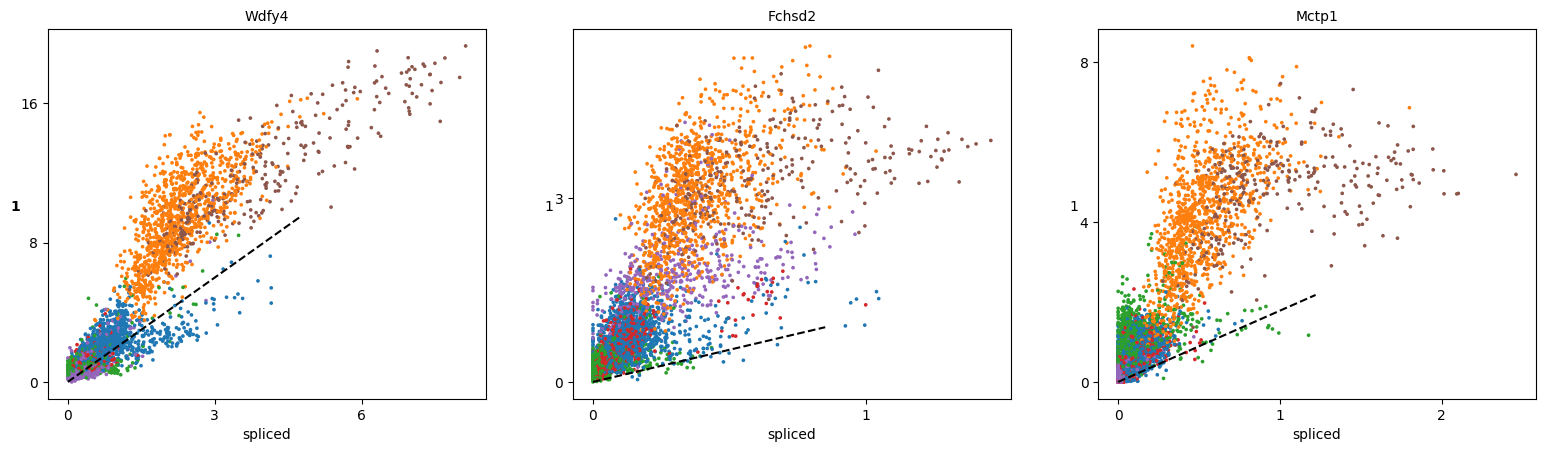

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

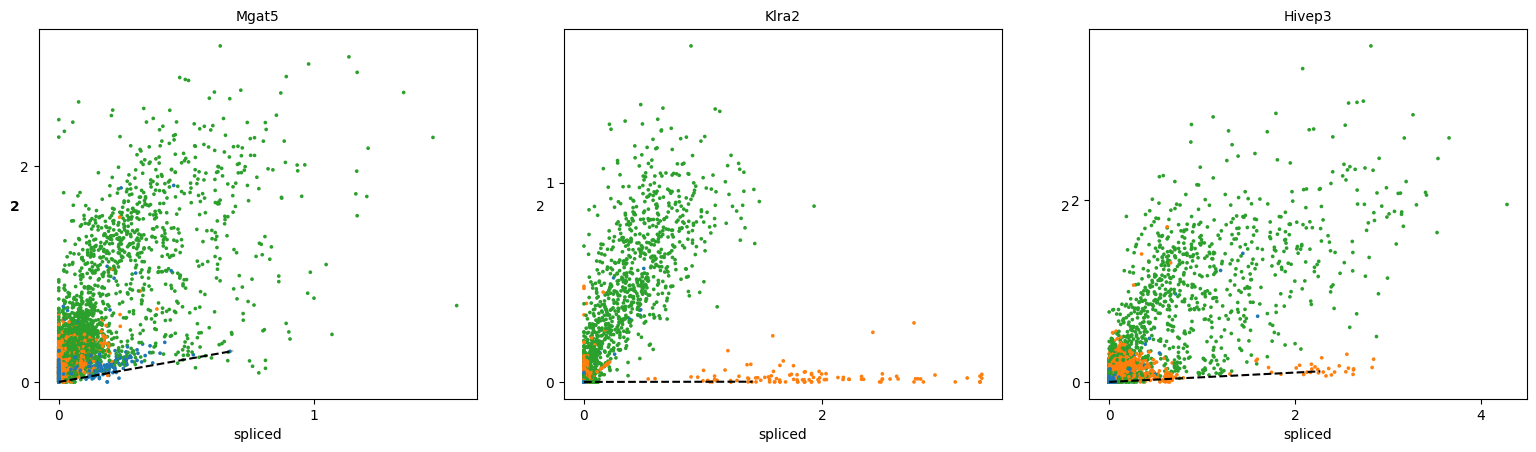

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

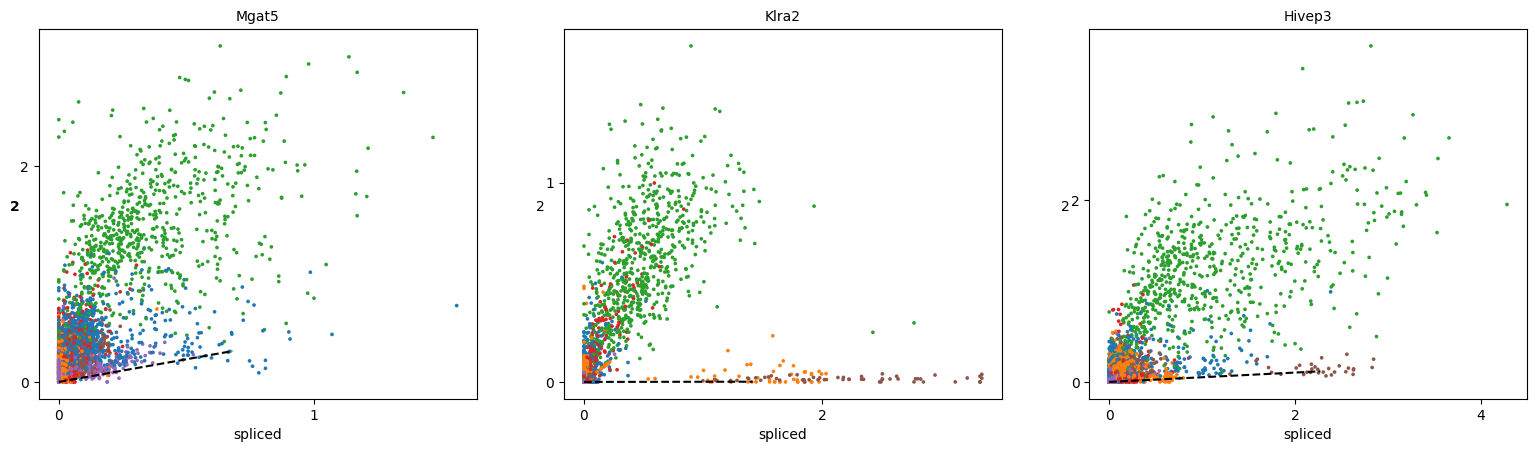

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

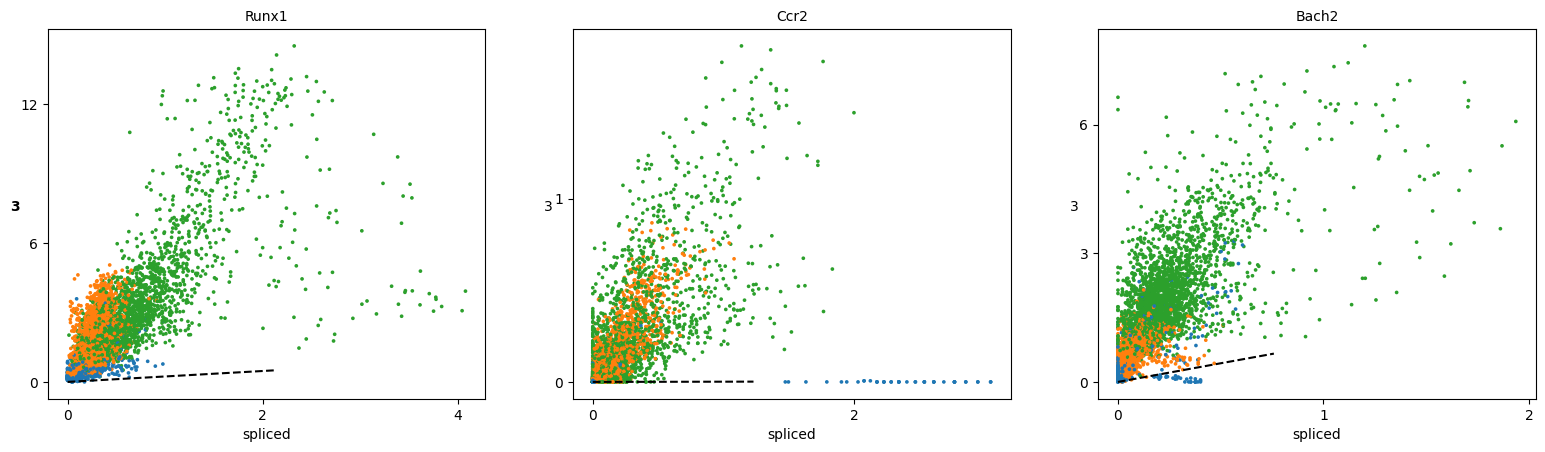

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

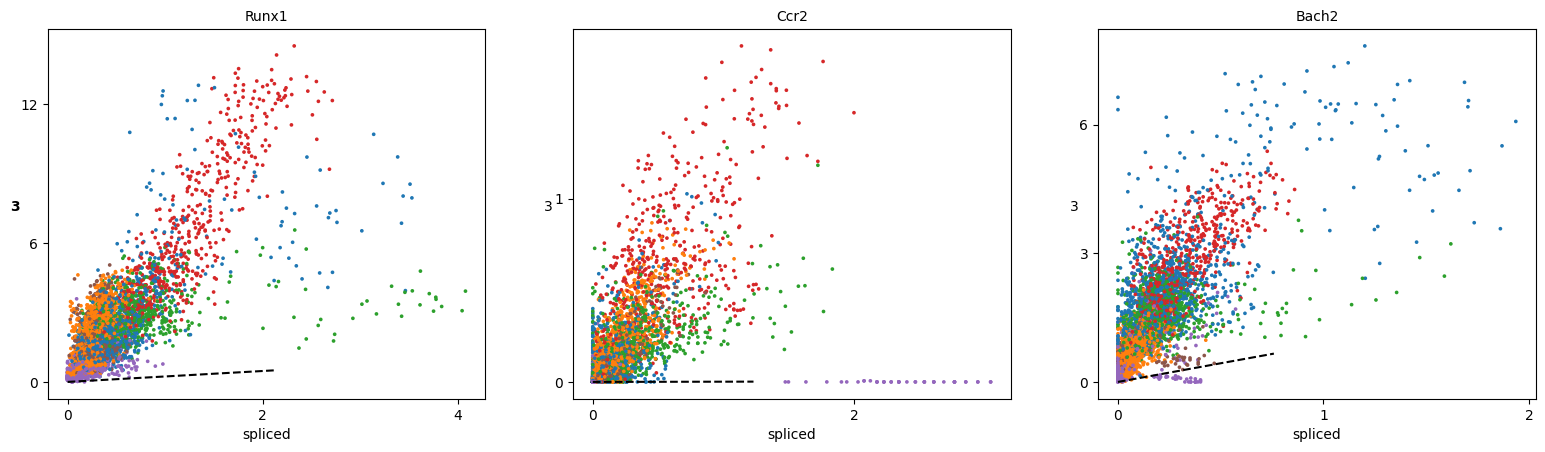

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

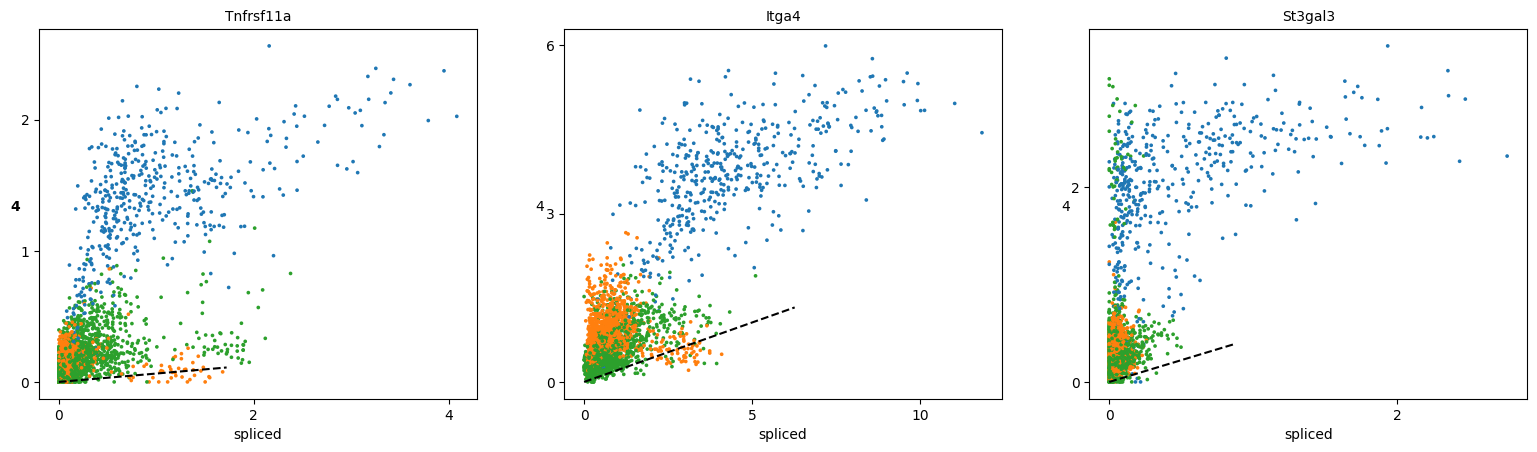

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

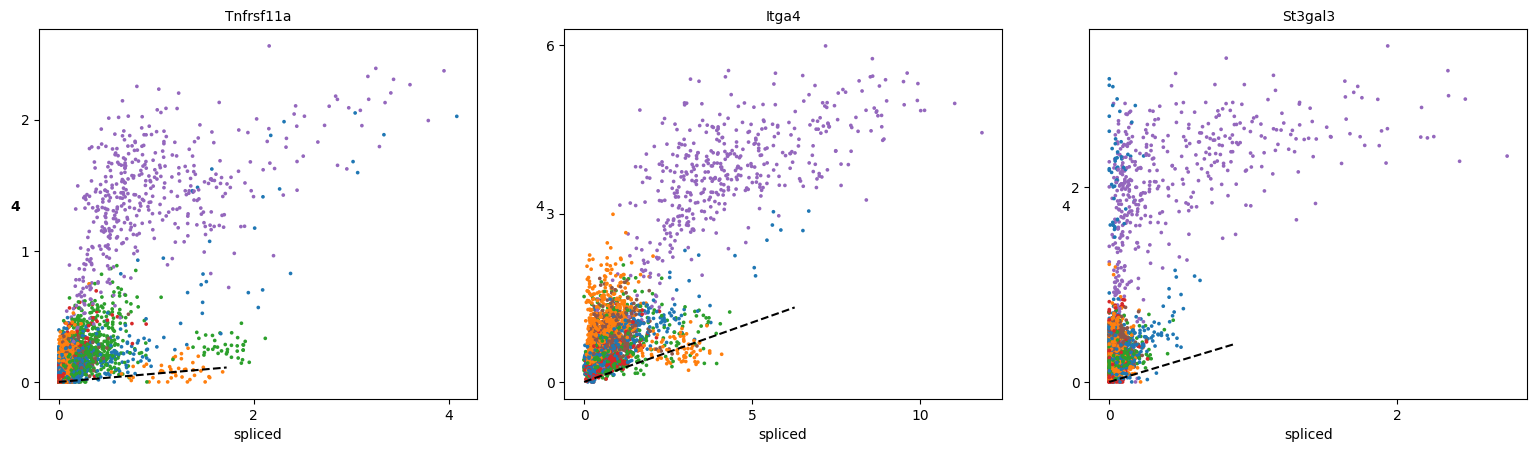

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

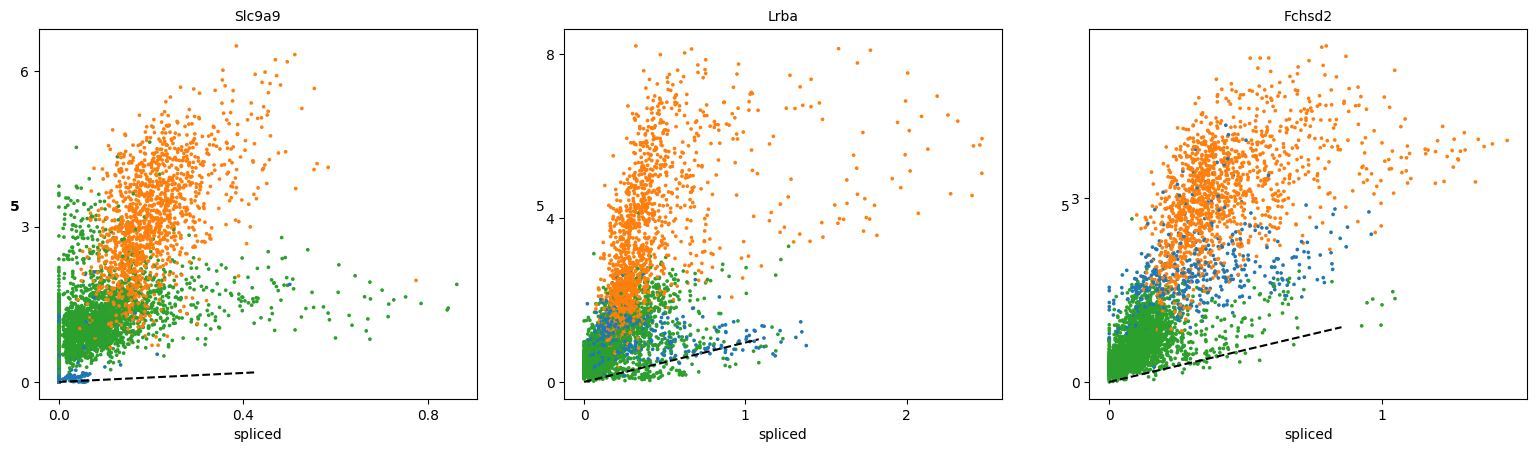

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

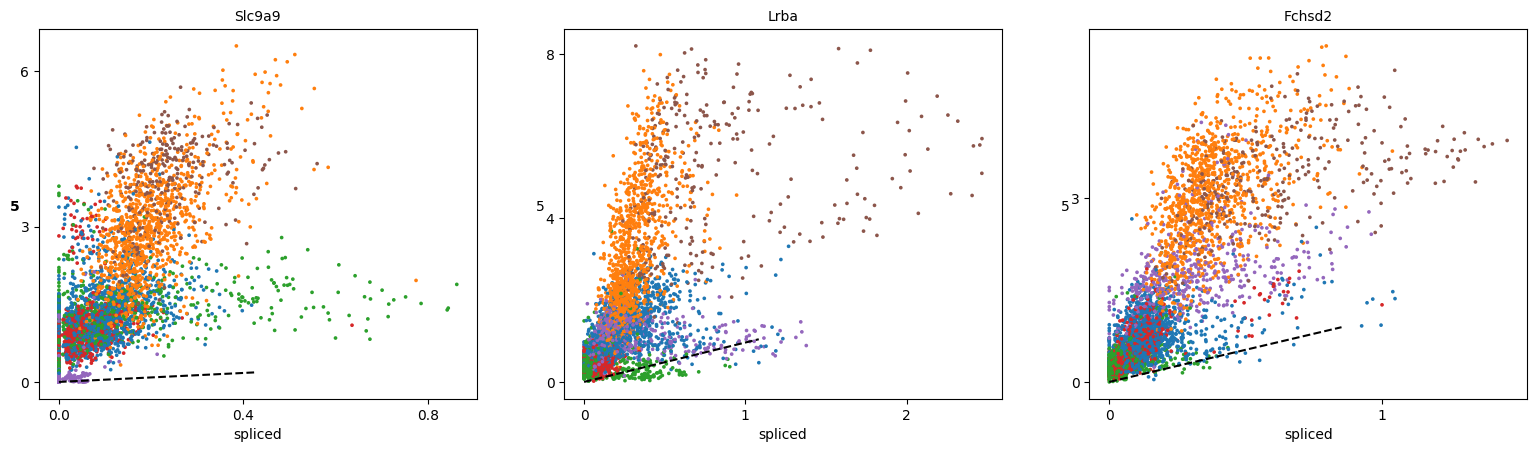

In [79]:
scv.tl.rank_velocity_genes(DCtum, groupby='louvain', min_corr=.3)

df = pd.DataFrame(DCtum.uns['rank_velocity_genes']['names'])
df.head()

scv.pl.scatter(DCtum, df.head(3)["0"].values, color = 'Population', ylabel = '0', ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["0"].values, color = 'louvain', ylabel = '0', ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["1"].values, color = 'Population', ylabel = "1", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["1"].values, color = 'louvain', ylabel = "1", ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["2"].values, color = 'Population', ylabel = "2", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["2"].values, color = 'louvain', ylabel = "2", ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["3"].values, color = 'Population', ylabel = "3", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["3"].values, color = 'louvain', ylabel = "3", ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["4"].values, color = 'Population', ylabel = "4", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["4"].values, color = 'louvain', ylabel = "4", ncols=3, linewidth=1.5)

scv.pl.scatter(DCtum, df.head(3)["5"].values, color = 'Population', ylabel = "5", ncols=3, linewidth=1.5)
scv.pl.scatter(DCtum, df.head(3)["5"].values, color = 'louvain', ylabel = "5", ncols=3, linewidth=1.5)

In [22]:
with open("../data/adata_new_orig.pickle", "rb") as f:
    adata = pickle.load(f)

In [ ]:
# A regarder dans adata_DC

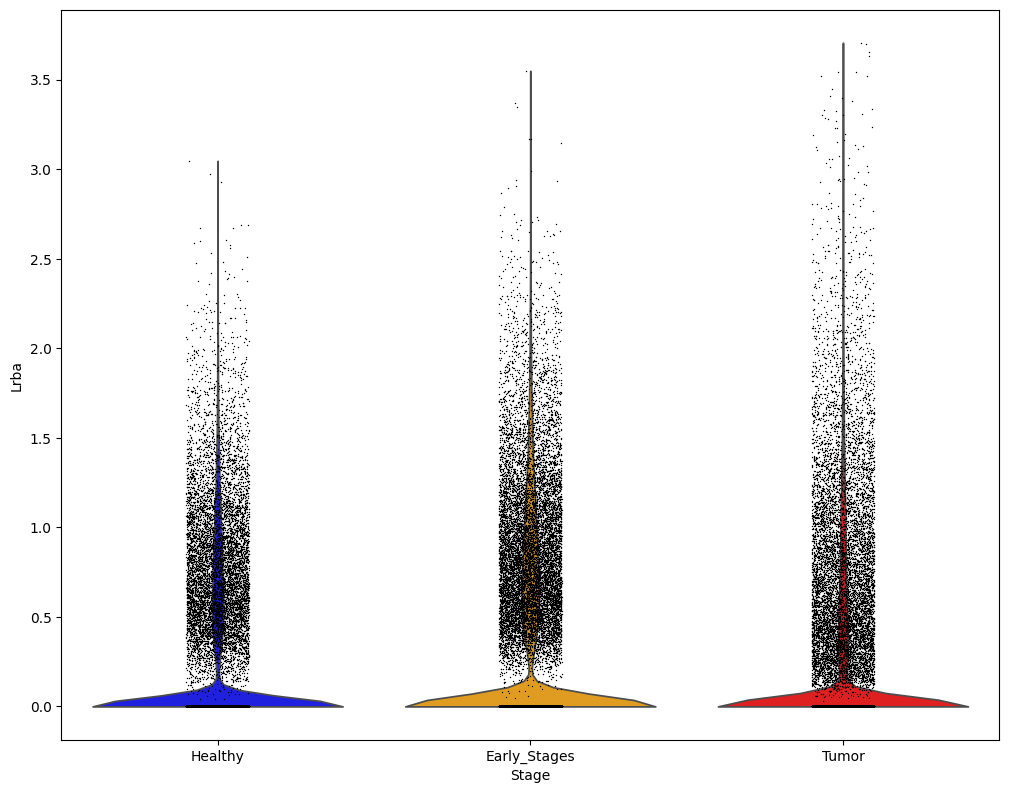

In [25]:
sc.pl.violin(adata, "Lrba", groupby="Stage")

/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/Users/mscavino/miniconda3/envs/scvelo/lib/python

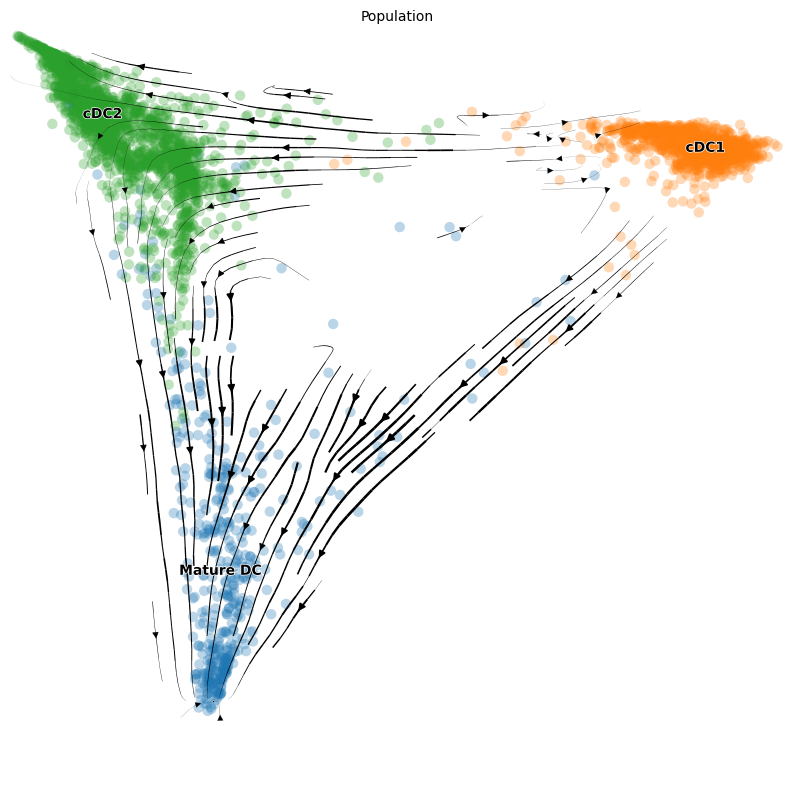

In [118]:
scv.pl.velocity_embedding_stream(DCtum, basis="diffmap", color = "Population")

In [115]:
DCtum

AnnData object with n_obs × n_vars = 4234 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Experiment_ID', 'Stage', 'New_Cell_ID', 'Population', 'Mouse_ID', 'Week_post Cre_activation', 'Sub_class_Stage', 'Mammary_glands', 'mouse_age_(Week)', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'louvain', 'n_counts', 'velocity_self_transition', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition'
    var: 'features', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'spearmans_score', 'velocity_score'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'Population_colors', 'louvain_colors', 'orig.ident_colors', 'rank_genes_groups', 'rank_genes_groups_filtered', 'dendrogram_louvain', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'diffmap_evals', 'rank_velocity_genes', 'dendrogram

In [ ]:
# Faire pareil mais avec les Healthy ? Peut être qu'on peut trouver des DC activés la dedans aussi